In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.set_index('id')
train

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP
...,...,...,...,...,...,...,...,...,...
749995,25,69,30,Clayey,Maize,8,16,6,28-28
749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17
749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26


In [30]:
print(f"Train dataset has {train.shape[0]} rows.")
print(f"Test dataset has {test.shape[0]} rows.")

Train dataset has 750000 rows.
Test dataset has 250000 rows.


# Data Visualization:

In [31]:
target = train.columns[-1]  # Assuming the last column is the target variable
num_features = [col for col in train.select_dtypes(exclude='object').columns if col != target]
cat_features = [col for col in train.select_dtypes(include='object').columns if col != target]
print("Numerical features:", num_features)
print("Categorical features:", cat_features)
print("Target column:", target)

Numerical features: ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
Categorical features: ['Soil Type', 'Crop Type']
Target column: Fertilizer Name


## Mutual Information:

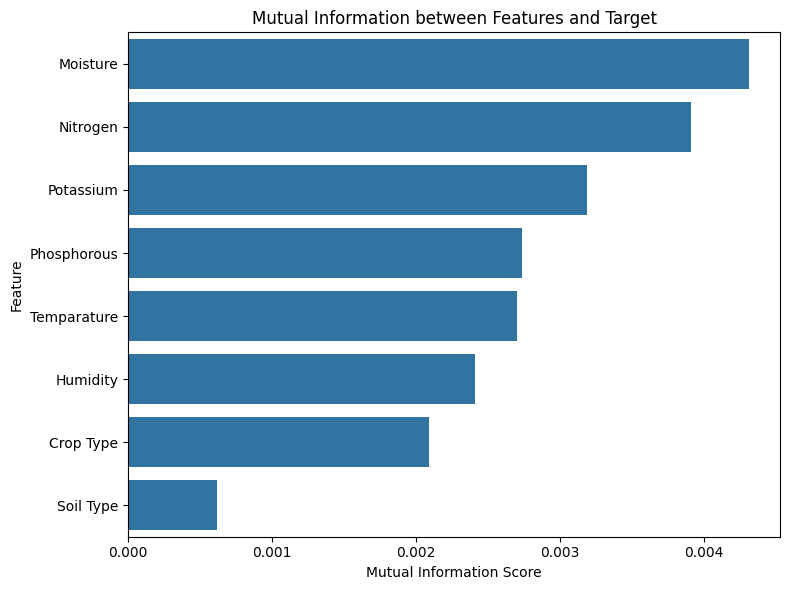

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif


# Copy the original data
X = train[num_features + cat_features].copy()

# Encode categorical features
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Target
y = train[target]

# Build discrete_features mask (True for categorical columns)
discrete_mask = [col in cat_features for col in X.columns]

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_mask, random_state=0)

# Sort and plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

mi_df = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=mi_df.values, y=mi_df.index, orient='h')
plt.title('Mutual Information between Features and Target')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Categorical Features:

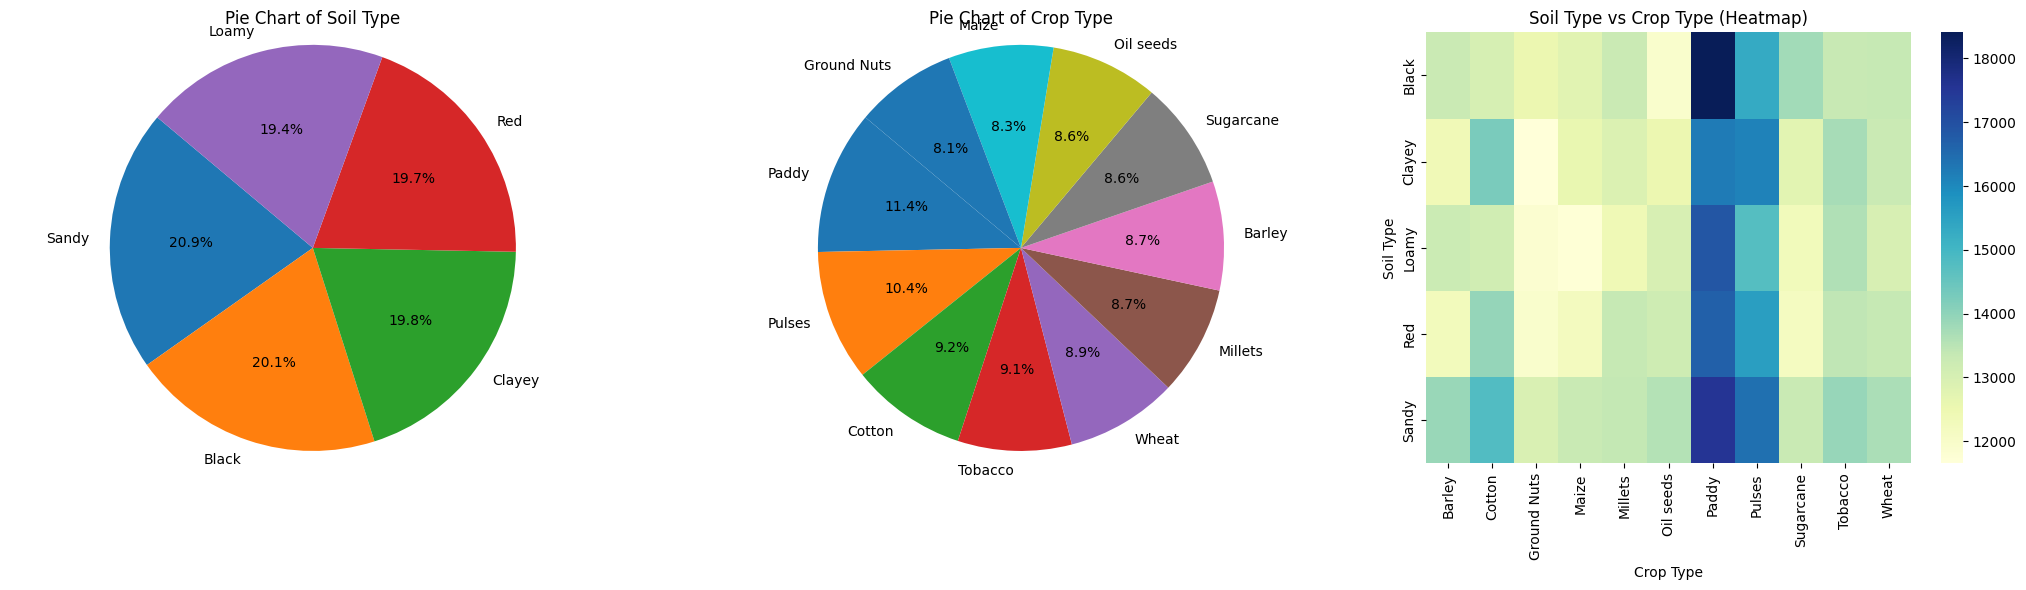

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Pie charts for categorical features
for i, col in enumerate(cat_features):
    value_counts = train[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'Pie Chart of {col}')
    axes[i].axis('equal')

cross_tab = pd.crosstab(train[cat_features[0]], train[cat_features[1]])

# Heatmap for relationship between two categorical features
sns.heatmap(cross_tab, ax=axes[2], cmap='YlGnBu', cbar=True)
axes[2].set_title(f'{cat_features[0]} vs {cat_features[1]} (Heatmap)')
axes[2].set_xlabel(cat_features[1])
axes[2].set_ylabel(cat_features[0])

plt.tight_layout()
plt.show()


## Numerical Features:

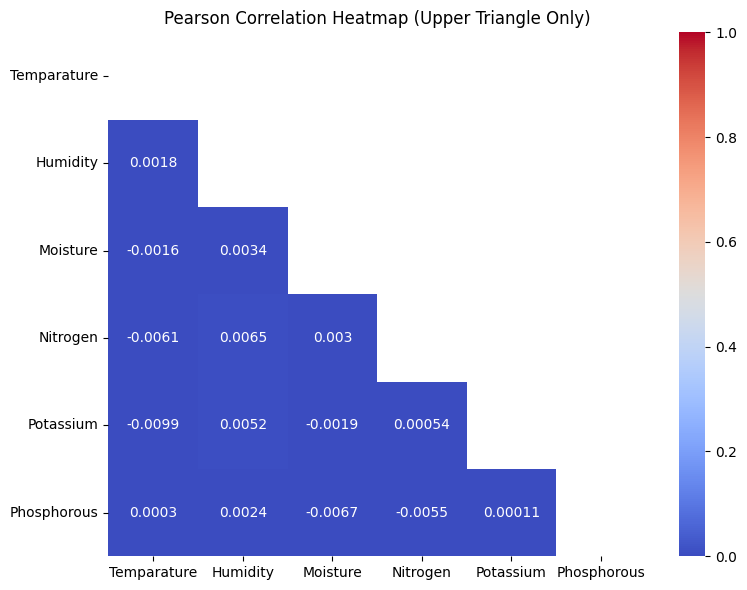

In [34]:
# Compute Pearson correlation for numerical features
pearson_corr = train[num_features].corr(method='pearson')

fig_corr, ax_corr = plt.subplots(figsize=(8, 6))

# Mask for the lower triangle
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))

sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', mask=mask, ax=ax_corr, vmin=0, vmax=1)
ax_corr.set_title('Pearson Correlation Heatmap (Upper Triangle Only)')

plt.tight_layout()
plt.show()

In [35]:
def add_npk_and_percentages(df, num_features):
    # Sum the last 3 columns in num_features to create NPK
    last3 = num_features[-3:]
    df['NPK'] = df[last3].sum(axis=1)
    # Calculate percentage for each last 3 column
    for col in last3:
        df[f'{col}_pct'] = df[col] / df['NPK'] * 100
    return df

# Example usage:
train = add_npk_and_percentages(train, num_features)
train.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,NPK,Nitrogen_pct,Potassium_pct,Phosphorous_pct
id,,,,,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,45,80.000000,8.888889,11.111111
1,27,69,65,Sandy,Millets,30,6,18,28-28,54,55.555556,11.111111,33.333333
2,29,63,32,Sandy,Millets,24,12,16,17-17-17,52,46.153846,23.076923,30.769231
3,35,62,54,Sandy,Barley,39,12,4,10-26-26,55,70.909091,21.818182,7.272727
4,35,58,43,Red,Paddy,37,2,16,DAP,55,67.272727,3.636364,29.090909


In [36]:
last3_cols = train.columns[-3:]
majority_col = train[last3_cols].idxmax(axis=1).str.replace('_pct', '')
train['Majority'] = majority_col
train[['Majority'] + list(last3_cols)].head()

,Majority,Nitrogen_pct,Potassium_pct,Phosphorous_pct
id,,,,
0,Nitrogen,80.000000,8.888889,11.111111
1,Nitrogen,55.555556,11.111111,33.333333
2,Nitrogen,46.153846,23.076923,30.769231
3,Nitrogen,70.909091,21.818182,7.272727
4,Nitrogen,67.272727,3.636364,29.090909


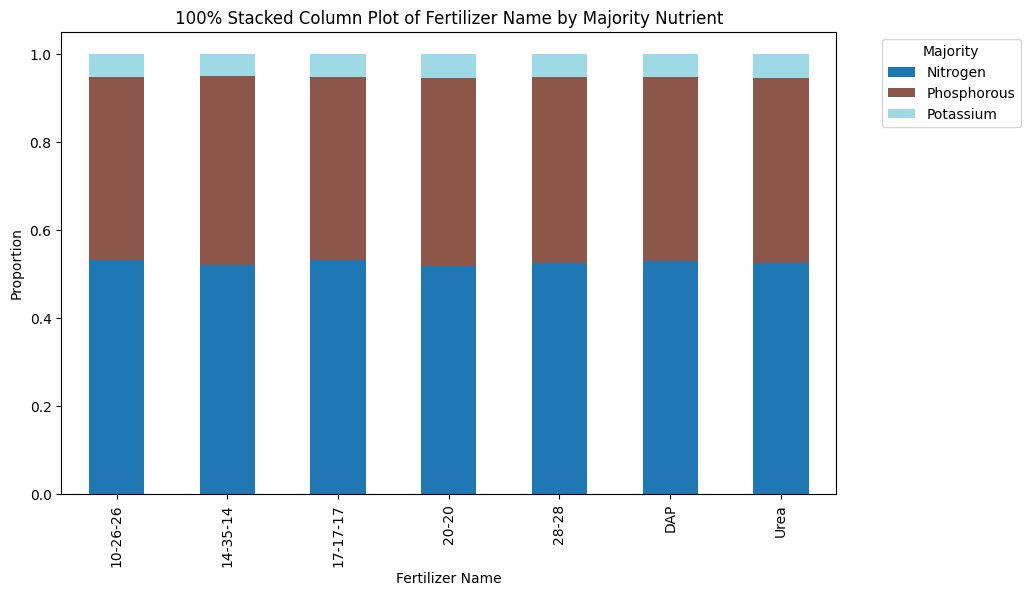

In [37]:
majority_by_target_counts = train.groupby([target, 'Majority']).size().unstack(fill_value=0)
majority_by_target_pct = majority_by_target_counts.div(majority_by_target_counts.sum(axis=1), axis=0)

majority_by_target_pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title('100% Stacked Column Plot of Fertilizer Name by Majority Nutrient')
plt.xlabel('Fertilizer Name')
plt.ylabel('Proportion')
plt.legend(title='Majority', bbox_to_anchor=(1.05, 1), loc='upper left')

C:\Users\ktran\AppData\Local\Temp\ipykernel_21152\2013719050.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



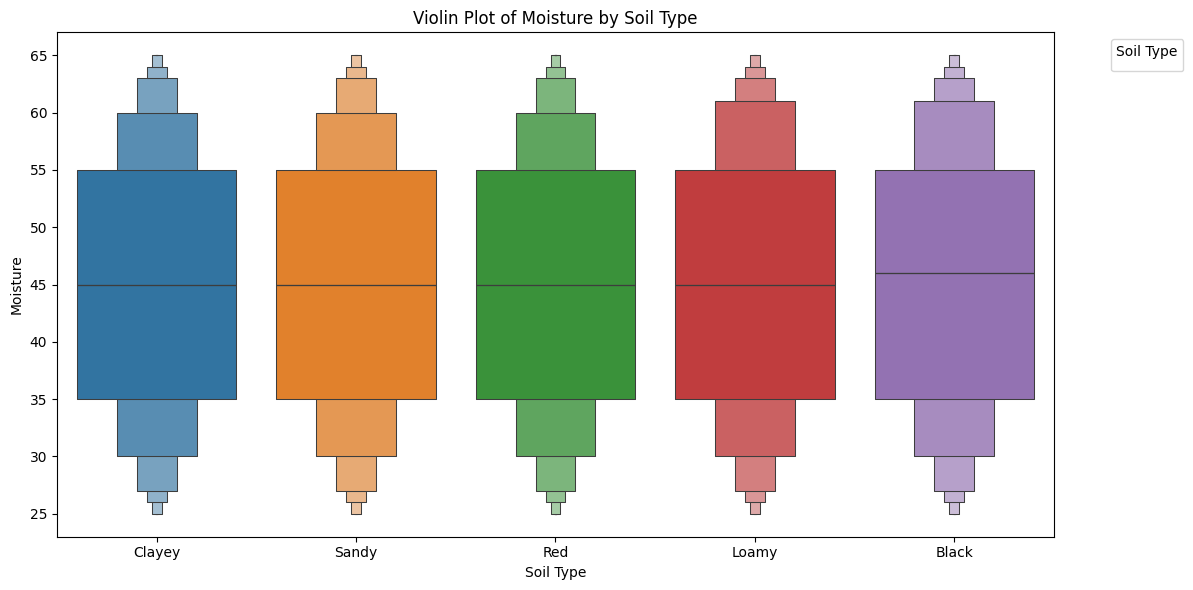

C:\Users\ktran\AppData\Local\Temp\ipykernel_21152\2013719050.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



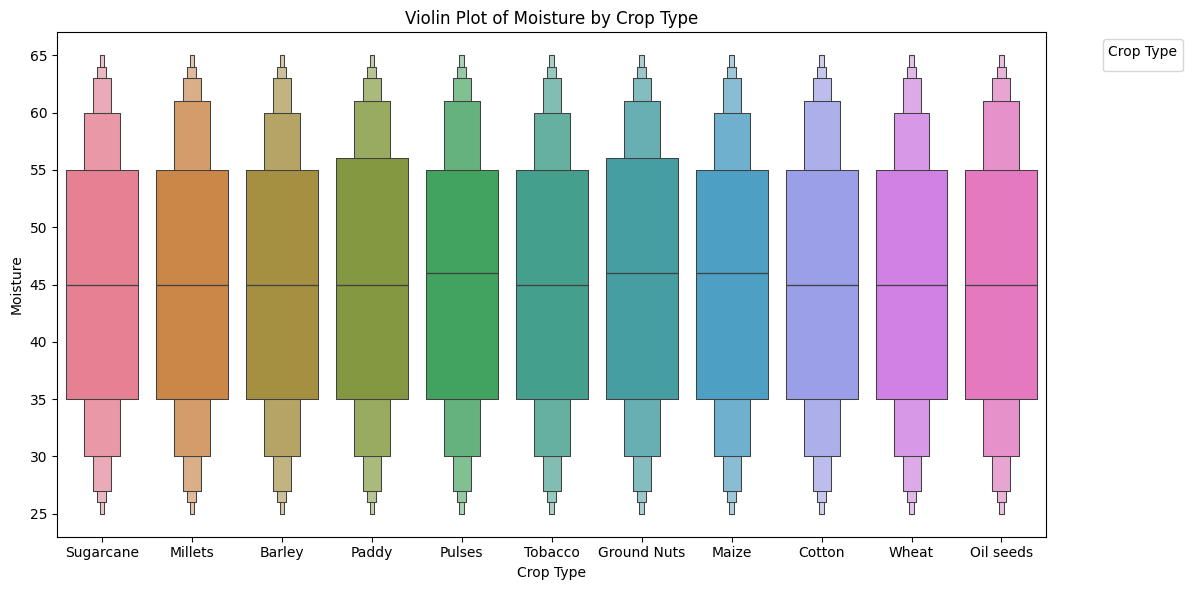

C:\Users\ktran\AppData\Local\Temp\ipykernel_21152\2013719050.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



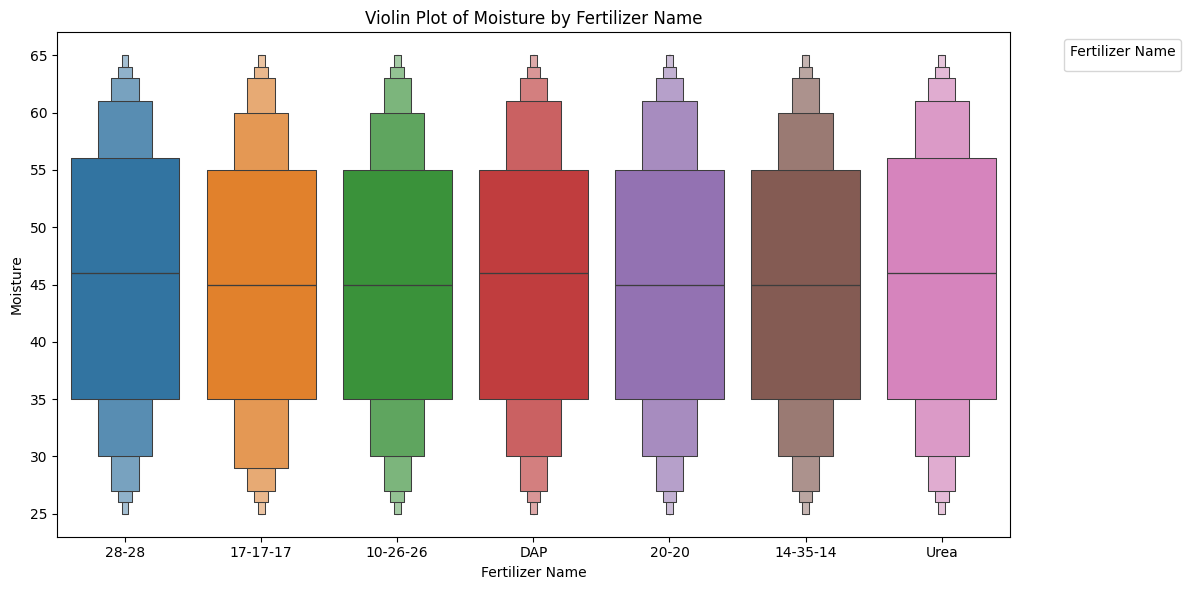

In [38]:
for cat_col in cat_features + [target]:
    plt.figure(figsize=(12, 6))
    sns.boxenplot(x=cat_col, y='Moisture', hue=cat_col, data=train)
    plt.title(f"Violin Plot of Moisture by {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Moisture")
    plt.legend(title=cat_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

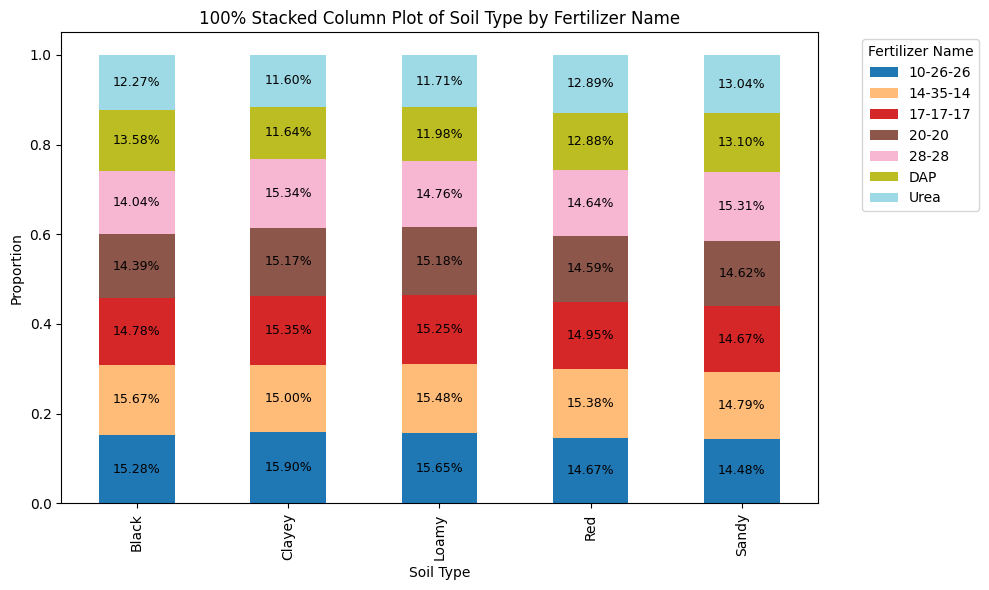

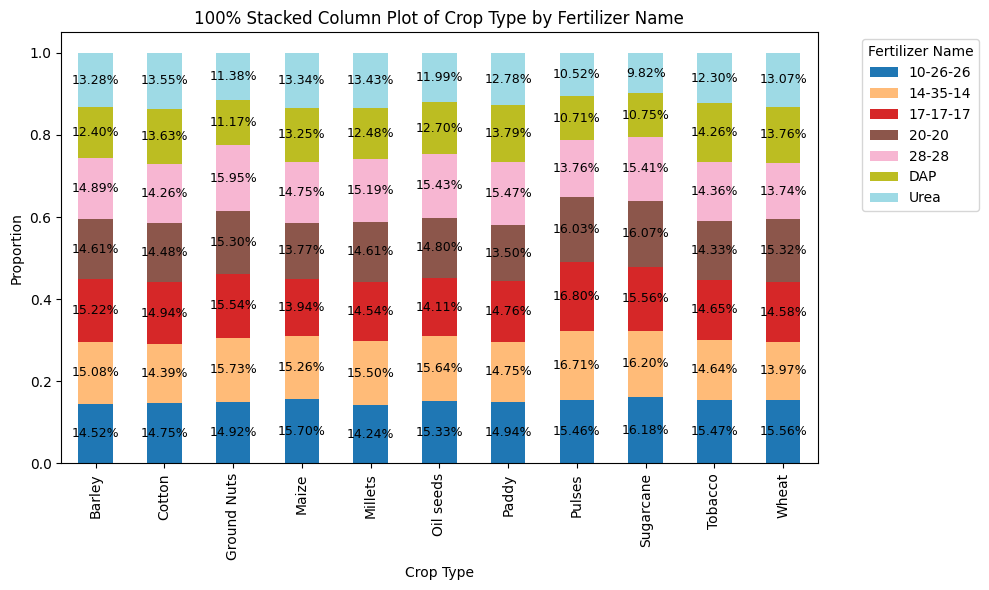

In [39]:
for col in cat_features:
    counts = train.groupby([col, target]).size().unstack(fill_value=0)
    pct = counts.div(counts.sum(axis=1), axis=0)
    ax = pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
    plt.title(f'100% Stacked Column Plot of {col} by {target}')
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # Add annotation
    for p in ax.patches:
        height = p.get_height()
        if height > 0.01:  # Only annotate if the bar is visible
            ax.annotate(f'{height*100:.2f}%', 
                        (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                        ha='center', va='center', fontsize=9, color='black')
    plt.show()

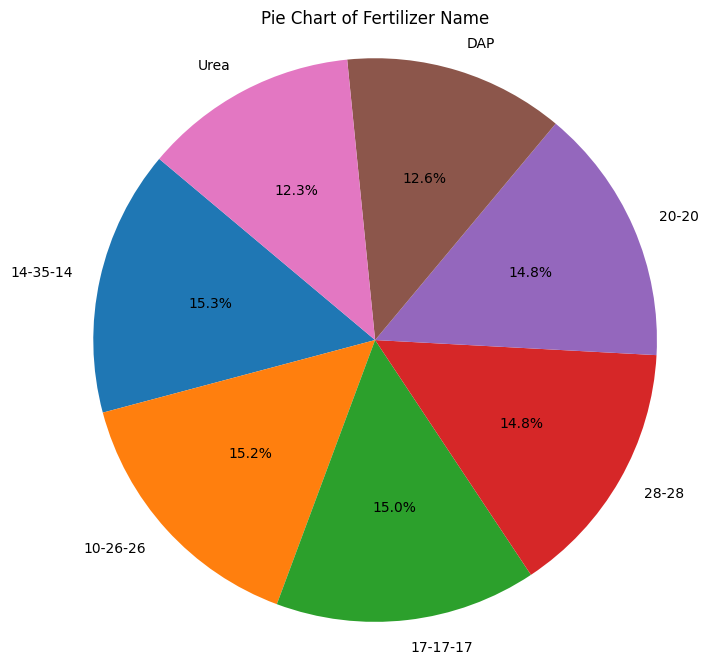

In [40]:
# Pie plot of the target variable (Fertilizer Name)
target_counts = train[target].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of {target}')
plt.axis('equal')
plt.show()

In [41]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd

# Define consistent color map
unique_targets = train[target].unique()
color_map = px.colors.qualitative.Plotly
target_color_dict = {val: color_map[i % len(color_map)] for i, val in enumerate(unique_targets)}

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        "Ribbon Chart - Soil Type", "Top 3 Count - Soil Type",
        "Ribbon Chart - Crop Type", "Top 3 Count - Crop Type"
    ],
    horizontal_spacing=0.15,
    vertical_spacing=0.15
)

for i, cat in enumerate(cat_features):
    row = i + 1

    freq = train.groupby([cat, target]).size().unstack(fill_value=0)
    ranks = freq.rank(axis=1, method='min', ascending=False)
    categories = freq.index.tolist()
    targets = freq.columns.tolist()

    # --- Column 1: Ribbon chart ---
    for t in targets:
        fig.add_trace(go.Scatter(
            x=categories,
            y=ranks[t],
            mode='lines+markers',
            name=t,
            line_shape='spline',
            line=dict(color=target_color_dict[t]),
            legendgroup=t,
            showlegend=(i == 0)  # show legend only once (row 1)
        ), row=row, col=1)

    # Add shaded area (cover exact x-values, ranks 1 to 3)
    fig.add_shape(
        type="rect",
        xref=f"x{(row-1)*2+1}",
        yref=f"y{(row-1)*2+1}",
        x0=categories[0],
        x1=categories[-1],
        y0=1, y1=3,
        fillcolor="LightGreen",
        opacity=0.3,
        layer="below",
        line_width=0,
        row=row, col=1
    )

    # --- Column 2: Top 3 Count Bar Chart ---
    top3_counts = (ranks <= 3).sum()
    count_df = top3_counts.reset_index()
    count_df.columns = [target, 'Top3_Count']

    for j in range(len(count_df)):
        t_val = count_df[target][j]
        fig.add_trace(go.Bar(
            x=[t_val],
            y=[count_df['Top3_Count'][j]],
            name=t_val,
            marker_color=target_color_dict[t_val],
            legendgroup=t_val,
            showlegend=False
        ), row=row, col=2)

# Final layout update


fig.update_layout(
    height=800,
    title_text="Ribbon Chart and Top 3 Target Frequency by Category",
    legend=dict(
        x=0.47,  # Centered between the two subplots (adjust as needed)
        y=0.5,
        xanchor="center",
        yanchor="middle",
        orientation="v",  # Vertical legend
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="black",
        borderwidth=1
    )
)

